In [1]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

### Instructions
For this part, fill in the required code and make the notebook work. This wll be very similar to the Skip-Gram model, but a little more difficult. Look for the """ FILL IN """ string to guide you.

In [2]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [3]:
!du -h text8

 95M	text8


In [4]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [5]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [6]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [7]:
words = TOKENIZER(text)
f = Counter(words)

In [8]:
len(words)

17005207

In [9]:
# Do a very crude filter on the text which removes all very popular words.
text = [word for word in words if f[word] > 5]

In [10]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [11]:
VOCAB = build_vocab_from_iterator([text])

In [12]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [13]:
stoi['as']

11

In [14]:
# Total number of words.
len(stoi)

63641

In [15]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [16]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [17]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [18]:
len(train_dataset)

7846873

In [19]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [20]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [21]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [22]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [23]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        # Get the left and right tokens.
        start = max(0, i-m)
        left_tokens = dataset[start:i]
        
        end = min(len(dataset)-1, i+m)
        right_tokens = dataset[i+1:end+1]
        
        # Check these are the same length, and if so use them to add a row of data. This should be a list like.
        # [a, c, b] where b is the center word.
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = token
                        
            x_list.extend(
                [w_context + [wc]]
            )
            
    return x_list

In [24]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [25]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [26]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [27]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 193, 5],
 [5, 1, 193],
 [193, 3133, 1],
 [1, 44, 3133],
 [3133, 59, 44],
 [44, 152, 59],
 [59, 117, 152],
 [152, 740, 117]]

In [28]:
len(train_x_list)// BATCH_SIZE

32579

In [29]:
# The number of things of BATCH_SIZE = 512.
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [30]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [31]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [32]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [33]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 3)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:,0:2], x[:,2]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, D) and this is what we get.
        
        # (N, 2, D)
        a = self.A(w_context)
        
        # (N, D)
        a_avg = torch.mean(a, dim=1)
        
        # Each of these is (N, D) since each target has 1 word.
        b = self.B(wc)
                
        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = torch.sum(a_avg * b, dim=1)
                
        return logits

In [34]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [35]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [36]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [37]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [38]:
validate_embeddings(model, valid_ids, itos)

money: demigods, causative, terre, atrahasis, prefatory, aquarist, gylfaginning, streamline, hyde, autobiography
lion: pollination, bans, lindbergh, sector, vivant, confronted, breeze, fingerprint, mayr, carpets
africa: lifetimes, myopia, carbondale, redonda, faisal, tsh, dreyer, brownies, insecticide, wagons
musician: warrants, tisdall, sightedness, lightweight, trait, vanuatu, presumptive, logie, elegy, thither
dance: marcello, seis, endymion, fractions, vhdl, topkapi, noblemen, pollo, lincoln, attainment




### Train the model

In [39]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
        
        # Zero the gradient so they don't accumulate.
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        #print("Batch size: ", batch_size)
        negative_samples = torch.multinomial(p, batch_size*K, replacement=True)
        #print("negative_samples: ", negative_samples.size())
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc =x_batch[:,0:2].to('cpu'), negative_samples
        
        #print("w_context: ", w_context.size())
        #print("wc: ", wc.size())
        
        """
        if w_context looks like below (batch_size = 3)
        [
        (a, b),
        (c, d),
        (e, f)
        ] and K = 2 we'd like to get:
        
        [
        (a, b),
        (a, b),
        (c, d), 
        (c, d),
        (e, f),
        (e, f)
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ])
        #print("w_context: ", w_context.size())
        # Remove the last dimension 1.
        wc = wc.view(wc.size()[0],1)
        #print("wc: ", wc.size())
        # Get the negative samples. This should be (N * K, 3).
        # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU.
        x_batch_negative = torch.concat([w_context, wc], axis=1).to(DEVICE)
        #print("x_batch_negative: ", x_batch_negative.shape)      
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        # Look at the Skip-Gram notebook.
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        # Get the new loss.
        total_loss += loss.item()
        # Update the batch count.
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [40]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]/var/folders/f8/mb2zprsj5wj1n9ygh0fcr3nw0000gn/T/ipykernel_7109/750430753.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
1it [00:00,  1.27it/s]

| epoch   1 |     0/32580 batches | loss    4.085 
money: demigods, causative, terre, atrahasis, prefatory, aquarist, gylfaginning, streamline, hyde, autobiography
lion: pollination, bans, lindbergh, sector, vivant, confronted, breeze, fingerprint, mayr, carpets
africa: lifetimes, myopia, carbondale, redonda, faisal, tsh, dreyer, brownies, insecticide, gnaeus
musician: warrants, tisdall, sightedness, lightweight, trait, vanuatu, presumptive, logie, elegy, thither
dance: marcello, seis, endymion, fractions, vhdl, topkapi, noblemen, pollo, lincoln, attainment




502it [16:51,  9.43it/s] 

| epoch   1 |   500/32580 batches | loss    3.716 
money: causative, demigods, terre, atrahasis, prefatory, gylfaginning, autobiography, aquarist, streamline, rabelais
lion: pollination, bans, lindbergh, sector, vivant, confronted, breeze, fingerprint, mayr, carpets
africa: lifetimes, myopia, redonda, carbondale, faisal, brownies, dreyer, tsh, chrysostom, multiples
musician: warrants, tisdall, sightedness, lightweight, vanuatu, trait, presumptive, logie, tarim, thither
dance: marcello, seis, endymion, fractions, vhdl, lincoln, pollo, noblemen, topkapi, attainment




1001it [17:38,  9.82it/s]

| epoch   1 |  1000/32580 batches | loss    3.357 
money: demigods, causative, terre, atrahasis, prefatory, gylfaginning, aquarist, streamline, autobiography, someone
lion: pollination, bans, lindbergh, vivant, sector, confronted, breeze, mayr, fingerprint, carpets
africa: myopia, lifetimes, redonda, carbondale, brownies, faisal, tsh, strains, chrysostom, decolonization
musician: warrants, tisdall, sightedness, lightweight, vanuatu, trait, presumptive, elegy, logie, roosevelts
dance: marcello, seis, endymion, fractions, vhdl, topkapi, attainment, noblemen, pollo, gokturks




1501it [18:24,  9.85it/s]

| epoch   1 |  1500/32580 batches | loss    3.026 
money: causative, demigods, terre, atrahasis, prefatory, aquarist, streamline, gylfaginning, autobiography, rabelais
lion: pollination, bans, lindbergh, vivant, sector, confronted, breeze, mayr, carpets, fingerprint
africa: myopia, lifetimes, redonda, carbondale, tsh, brownies, decolonization, insecticide, faisal, difficulty
musician: warrants, tisdall, sightedness, lightweight, vanuatu, trait, presumptive, logie, roosevelts, lopsided
dance: marcello, seis, fractions, endymion, vhdl, gokturks, pollo, attainment, studies, topkapi




2001it [19:10,  9.89it/s]

| epoch   1 |  2000/32580 batches | loss    2.788 
money: causative, demigods, terre, prefatory, atrahasis, streamline, aquarist, gylfaginning, someone, autobiography
lion: pollination, bans, lindbergh, vivant, sector, confronted, mayr, breeze, fingerprint, carpets
africa: myopia, lifetimes, redonda, tsh, brownies, strains, carbondale, insecticide, difficulty, decolonization
musician: warrants, tisdall, sightedness, vanuatu, lightweight, trait, presumptive, logie, roosevelts, thither
dance: marcello, seis, fractions, endymion, vhdl, gokturks, studies, breaded, attainment, pollo




2502it [19:56,  9.43it/s]

| epoch   1 |  2500/32580 batches | loss    2.619 
money: causative, demigods, prefatory, terre, atrahasis, streamline, aquarist, someone, gylfaginning, published
lion: pollination, bans, lindbergh, sector, vivant, confronted, mayr, breeze, fingerprint, carpets
africa: myopia, redonda, lifetimes, tsh, kill, brownies, strains, difficulty, zion, decolonization
musician: warrants, tisdall, sightedness, lightweight, vanuatu, trait, logie, presumptive, roosevelts, kivu
dance: seis, marcello, fractions, endymion, studies, vhdl, gokturks, pollo, breaded, solway




3001it [28:38, 71.30s/it]

| epoch   1 |  3000/32580 batches | loss    2.485 
money: causative, demigods, prefatory, published, someone, terre, streamline, about, aquarist, gylfaginning
lion: pollination, bans, lindbergh, vivant, sector, mayr, confronted, fingerprint, breeze, carpets
africa: myopia, redonda, kill, lifetimes, strains, tsh, zion, brownies, difficulty, decolonization
musician: warrants, tisdall, sightedness, trait, lightweight, vanuatu, th, logie, roosevelts, write
dance: seis, marcello, fractions, studies, endymion, gokturks, vhdl, breaded, solway, pollo




3499it [29:24, 10.81it/s]

| epoch   1 |  3500/32580 batches | loss    2.377 


3502it [36:42, 54.17s/it]

money: causative, demigods, published, about, prefatory, recent, someone, terre, streamline, aquarist
lion: pollination, bans, lindbergh, vivant, sector, mayr, confronted, fingerprint, breeze, kalinin
africa: myopia, kill, city, form, redonda, used, god, story, strains, include
musician: warrants, tisdall, th, vanuatu, lightweight, sightedness, trait, ii, write, logie
dance: seis, marcello, fractions, studies, endymion, gokturks, breaded, solway, vhdl, recognition




4000it [37:29, 10.62it/s]

| epoch   1 |  4000/32580 batches | loss    2.294 
money: causative, about, published, demigods, recent, someone, streamline, prefatory, given, record
lion: pollination, bans, lindbergh, sector, vivant, mayr, confronted, fingerprint, breeze, kalinin
africa: myopia, city, form, kill, west, god, found, used, others, university
musician: warrants, tisdall, th, vanuatu, write, lightweight, sightedness, trait, french, ii
dance: seis, marcello, studies, fractions, endymion, gokturks, party, recognition, breaded, solway




4502it [38:17,  9.43it/s]

| epoch   1 |  4500/32580 batches | loss    2.220 
money: published, causative, about, recent, given, name, demigods, record, someone, years
lion: pollination, bans, lindbergh, sector, vivant, mayr, confronted, fingerprint, breeze, kalinin
africa: city, form, west, found, others, god, all, myopia, include, th
musician: warrants, tisdall, th, write, french, ii, then, vanuatu, lightweight, trait
dance: seis, marcello, studies, fractions, m, party, endymion, recognition, gokturks, breaded




5000it [39:03, 10.71it/s]

| epoch   1 |  5000/32580 batches | loss    2.159 
money: published, about, given, recent, name, created, causative, record, such, someone
lion: pollination, bans, lindbergh, sector, vivant, mayr, confronted, fingerprint, breeze, kalinin
africa: city, west, form, others, god, found, all, th, used, include
musician: warrants, th, tisdall, write, then, french, ii, three, vanuatu, trait
dance: seis, marcello, studies, party, m, fractions, recognition, area, endymion, breaded




5501it [39:50,  9.82it/s]

| epoch   1 |  5500/32580 batches | loss    2.102 
money: published, about, given, name, recent, created, record, along, such, years
lion: pollination, bans, lindbergh, sector, vivant, mayr, confronted, breeze, kalinin, fingerprint
africa: west, others, form, city, found, god, th, used, all, include
musician: warrants, th, tisdall, french, write, then, ii, three, others, four
dance: seis, studies, marcello, party, m, area, recognition, fractions, japanese, yet




6002it [40:37,  9.44it/s]

| epoch   1 |  6000/32580 batches | loss    2.054 
money: published, about, given, recent, name, along, created, record, such, there
lion: pollination, bans, lindbergh, sector, mayr, vivant, confronted, kalinin, fingerprint, breeze
africa: west, others, form, city, found, god, used, all, th, end
musician: warrants, th, french, write, tisdall, then, ii, british, three, others
dance: studies, seis, party, marcello, area, m, japanese, recognition, yet, some




6502it [41:24,  9.39it/s]

| epoch   1 |  6500/32580 batches | loss    2.013 
money: published, given, about, created, recent, name, record, along, well, there
lion: pollination, bans, lindbergh, sector, mayr, vivant, confronted, fingerprint, breeze, kalinin
africa: west, form, others, city, god, th, found, used, all, end
musician: th, warrants, french, ii, write, then, three, four, others, tisdall
dance: studies, party, seis, area, m, marcello, japanese, recognition, yet, some




7002it [42:11,  9.24it/s]

| epoch   1 |  7000/32580 batches | loss    1.981 
money: published, given, about, created, recent, record, along, well, name, city
lion: pollination, bans, sector, lindbergh, mayr, vivant, confronted, fingerprint, kalinin, breeze
africa: west, form, others, city, god, th, found, english, end, all
musician: th, warrants, french, ii, then, write, three, most, way, others
dance: studies, party, area, seis, m, japanese, marcello, some, yet, recognition




7501it [42:58,  9.64it/s]

| epoch   1 |  7500/32580 batches | loss    1.945 
money: published, given, created, well, along, record, about, recent, name, city
lion: pollination, bans, sector, lindbergh, mayr, vivant, confronted, kalinin, fingerprint, breeze
africa: west, form, th, city, god, example, found, others, end, english
musician: th, french, warrants, ii, then, three, write, most, five, others
dance: studies, party, area, m, seis, japanese, marcello, some, name, only




8002it [43:45,  9.27it/s]

| epoch   1 |  8000/32580 batches | loss    1.915 
money: published, given, created, along, well, recent, name, about, record, city
lion: pollination, bans, sector, lindbergh, mayr, vivant, confronted, kalinin, fingerprint, breeze
africa: west, form, end, th, example, others, god, city, found, english
musician: th, french, ii, three, warrants, five, six, then, write, u
dance: studies, party, area, m, japanese, some, name, seis, image, only




8502it [44:32,  9.32it/s]

| epoch   1 |  8500/32580 batches | loss    1.887 
money: given, published, created, well, along, recent, name, economy, record, city
lion: pollination, bans, sector, lindbergh, mayr, vivant, confronted, kalinin, breeze, fingerprint
africa: west, end, form, th, example, others, god, found, city, english
musician: th, french, ii, three, u, others, six, way, parts, write
dance: studies, party, area, name, m, japanese, some, only, seis, image




9002it [45:19,  9.27it/s]

| epoch   1 |  9000/32580 batches | loss    1.861 
money: given, published, created, well, along, recent, name, economy, record, r
lion: pollination, sector, bans, lindbergh, mayr, vivant, confronted, kalinin, fingerprint, breeze
africa: end, west, example, form, th, found, god, others, city, america
musician: th, french, ii, u, others, parts, way, group, three, six
dance: studies, party, name, area, m, japanese, some, yet, only, image




9502it [46:05,  9.34it/s]

| epoch   1 |  9500/32580 batches | loss    1.841 
money: given, published, created, recent, along, well, name, economy, r, record
lion: pollination, sector, bans, lindbergh, mayr, vivant, confronted, months, kalinin, fingerprint
africa: end, west, th, example, found, god, form, others, america, work
musician: th, french, ii, u, parts, others, way, six, group, british
dance: studies, party, name, area, japanese, some, image, only, m, province




10002it [46:52,  9.32it/s]

| epoch   1 | 10000/32580 batches | loss    1.814 
money: given, published, recent, well, along, created, name, r, economy, about
lion: pollination, sector, bans, mayr, lindbergh, months, vivant, confronted, authors, kalinin
africa: end, west, example, th, found, america, god, others, form, work
musician: th, french, u, ii, parts, six, others, group, british, way
dance: studies, party, name, area, some, japanese, only, m, image, g




10502it [47:39,  9.17it/s]

| epoch   1 | 10500/32580 batches | loss    1.792 
money: given, published, well, created, along, recent, economy, r, name, death
lion: pollination, sector, bans, mayr, lindbergh, months, vivant, confronted, authors, settled
africa: end, west, america, example, found, th, god, form, others, england
musician: th, french, u, parts, ii, six, way, group, three, british
dance: studies, party, name, area, japanese, only, m, g, few, because




11001it [48:25,  9.65it/s]

| epoch   1 | 11000/32580 batches | loss    1.773 
money: given, published, created, along, well, recent, economy, death, u, found
lion: pollination, sector, bans, lindbergh, mayr, months, vivant, confronted, settled, authors
africa: end, america, west, example, found, god, th, england, form, others
musician: th, french, u, parts, three, six, way, group, english, ii
dance: studies, name, party, area, japanese, only, m, women, fact, g




11502it [49:12,  9.35it/s]

| epoch   1 | 11500/32580 batches | loss    1.762 
money: given, published, created, well, along, recent, found, economy, york, u
lion: pollination, sector, bans, lindbergh, mayr, months, vivant, settled, confronted, authors
africa: end, america, west, th, found, god, england, example, others, work
musician: th, french, u, parts, six, way, group, actor, three, english
dance: name, studies, party, japanese, area, women, only, fact, m, title




12002it [49:59,  9.22it/s]

| epoch   1 | 12000/32580 batches | loss    1.739 
money: given, created, published, well, along, recent, death, found, u, economy
lion: pollination, sector, bans, months, lindbergh, mayr, settled, authors, vivant, confronted
africa: end, america, west, th, god, england, example, found, others, president
musician: th, u, french, three, six, actor, parts, group, way, english
dance: name, studies, party, japanese, women, fact, some, result, area, list




12502it [50:46,  9.18it/s]

| epoch   1 | 12500/32580 batches | loss    1.719 
money: given, created, published, well, record, death, along, economy, u, york
lion: pollination, sector, months, bans, mayr, lindbergh, settled, authors, vivant, confronted
africa: end, america, west, england, found, god, th, example, others, president
musician: th, u, french, actor, parts, group, three, six, way, seven
dance: name, studies, party, women, result, japanese, only, province, fact, area




13001it [51:32,  9.71it/s]

| epoch   1 | 13000/32580 batches | loss    1.712 
money: created, published, given, well, addition, record, u, economy, death, york
lion: sector, pollination, months, bans, mayr, settled, authors, lindbergh, vivant, confronted
africa: end, america, west, england, th, found, example, god, others, south
musician: th, u, actor, french, parts, three, group, six, singer, play
dance: name, party, studies, women, province, only, result, fact, title, available




13501it [52:19,  9.57it/s]

| epoch   1 | 13500/32580 batches | loss    1.694 
money: published, created, given, well, addition, record, u, along, return, york
lion: sector, pollination, months, settled, bans, mayr, authors, lindbergh, vivant, derived
africa: end, america, west, england, th, god, found, example, south, others
musician: th, u, actor, french, parts, three, six, group, singer, seven
dance: name, party, studies, women, province, result, title, only, fact, u




14001it [53:06,  9.67it/s]

| epoch   1 | 14000/32580 batches | loss    1.681 
money: created, published, given, well, addition, record, view, u, return, york
lion: sector, pollination, months, bans, settled, authors, mayr, lindbergh, derived, vivant
africa: end, america, west, england, th, south, found, god, example, president
musician: th, u, actor, three, six, parts, french, singer, four, way
dance: name, studies, party, women, province, result, title, fact, list, u




14502it [53:53,  9.33it/s]

| epoch   1 | 14500/32580 batches | loss    1.669 
money: created, published, given, well, addition, record, found, view, return, recent
lion: sector, pollination, months, authors, settled, bans, mayr, derived, lindbergh, vivant
africa: end, america, west, england, th, south, found, god, example, united
musician: th, actor, u, parts, six, french, singer, three, seven, play
dance: name, studies, party, women, province, result, title, fact, list, u




15002it [54:39,  9.31it/s]

| epoch   1 | 15000/32580 batches | loss    1.657 
money: created, published, addition, well, given, found, recent, view, record, able
lion: sector, pollination, months, authors, settled, mayr, bans, derived, modern, lindbergh
africa: end, america, west, england, th, south, found, europe, united, part
musician: th, actor, u, six, singer, parts, seven, french, eight, group
dance: name, studies, party, province, women, result, title, list, fact, u




15501it [55:26,  9.64it/s]

| epoch   1 | 15500/32580 batches | loss    1.645 
money: created, published, addition, found, well, recent, view, return, able, record
lion: sector, pollination, months, authors, settled, derived, mayr, modern, bans, lindbergh
africa: end, america, west, england, th, south, found, united, europe, part
musician: th, actor, singer, u, six, parts, french, seven, group, way
dance: studies, name, province, party, women, result, title, list, fact, support




16000it [56:13, 10.78it/s]

| epoch   1 | 16000/32580 batches | loss    1.632 
money: created, published, addition, recent, return, well, found, view, able, record
lion: sector, pollination, months, authors, settled, derived, mayr, modern, bans, remain
africa: america, end, england, west, south, th, found, europe, part, united
musician: th, actor, singer, u, six, parts, french, seven, play, way
dance: studies, name, province, result, women, party, title, list, fact, support




16502it [56:59,  9.34it/s]

| epoch   1 | 16500/32580 batches | loss    1.621 
money: created, published, addition, recent, return, found, able, view, well, given
lion: sector, months, pollination, authors, derived, settled, modern, mayr, bans, remain
africa: america, end, west, england, th, south, found, europe, united, central
musician: th, actor, singer, u, parts, six, seven, eight, french, play
dance: studies, province, name, title, result, women, party, list, fact, u




17002it [57:46,  9.37it/s]

| epoch   1 | 17000/32580 batches | loss    1.616 
money: created, addition, published, recent, return, view, able, well, found, u
lion: sector, months, pollination, settled, authors, derived, modern, mayr, bans, remain
africa: america, end, england, west, th, south, found, europe, united, god
musician: th, actor, singer, u, seven, six, parts, french, way, eight
dance: studies, province, name, title, women, result, list, fact, party, class




17502it [58:33,  9.19it/s]

| epoch   1 | 17500/32580 batches | loss    1.607 
money: created, addition, published, recent, return, view, able, found, well, given
lion: sector, months, pollination, settled, authors, derived, modern, mayr, bans, remain
africa: america, end, england, west, th, south, europe, united, found, china
musician: th, actor, singer, u, seven, parts, six, eight, french, four
dance: studies, province, name, result, women, title, list, party, fact, class




18000it [59:19, 10.64it/s]

| epoch   1 | 18000/32580 batches | loss    1.597 
money: created, addition, published, recent, view, return, found, able, well, zero
lion: sector, months, authors, settled, pollination, derived, modern, mayr, jazz, remain
africa: america, end, england, west, th, south, europe, united, found, china
musician: th, actor, singer, u, seven, parts, six, eight, three, zero
dance: studies, province, name, list, women, result, title, party, fact, class




18500it [1:00:06, 10.74it/s]

| epoch   1 | 18500/32580 batches | loss    1.584 
money: addition, created, published, return, able, found, recent, view, well, practice
lion: sector, months, authors, settled, pollination, derived, modern, jazz, mayr, introduction
africa: america, end, west, england, th, south, europe, united, china, central
musician: actor, th, singer, u, seven, six, parts, zero, four, eight
dance: province, studies, name, women, list, result, title, class, fact, party




19002it [1:00:53,  9.40it/s]

| epoch   1 | 19000/32580 batches | loss    1.579 
money: addition, created, published, able, return, found, recent, view, well, given
lion: sector, months, settled, authors, derived, pollination, modern, story, introduction, jazz
africa: america, end, england, west, th, south, europe, united, central, china
musician: th, actor, singer, u, six, seven, zero, parts, four, eight
dance: province, studies, title, result, women, list, name, fact, class, study




19501it [1:01:40,  9.72it/s]

| epoch   1 | 19500/32580 batches | loss    1.571 
money: addition, created, published, able, return, found, given, view, recent, practice
lion: sector, months, authors, settled, derived, pollination, modern, introduction, story, deal
africa: america, end, england, west, th, south, europe, united, china, central
musician: actor, th, singer, six, u, parts, seven, zero, eight, french
dance: province, studies, title, list, women, result, name, fact, class, study




20002it [1:02:28,  9.80it/s]

| epoch   1 | 20000/32580 batches | loss    1.558 
money: addition, created, able, published, return, found, view, recent, fact, given
lion: sector, months, authors, settled, derived, pollination, modern, story, introduction, deal
africa: america, end, england, west, south, th, europe, china, united, central
musician: actor, th, singer, six, u, parts, seven, eight, zero, battle
dance: province, studies, title, women, result, list, fact, study, name, class




20502it [1:03:13,  9.82it/s]

| epoch   1 | 20500/32580 batches | loss    1.554 
money: addition, able, published, created, return, found, view, given, practice, battle
lion: sector, months, settled, authors, derived, pollination, modern, story, introduction, deal
africa: america, end, england, west, south, china, europe, th, united, india
musician: actor, singer, th, u, six, parts, seven, eight, nine, battle
dance: province, studies, title, result, name, study, fact, women, list, influence




21002it [1:04:04,  8.99it/s]

| epoch   1 | 21000/32580 batches | loss    1.545 
money: addition, able, return, published, created, found, view, battle, given, practice
lion: sector, months, derived, settled, authors, modern, pollination, introduction, deal, revolution
africa: america, end, england, west, china, europe, south, india, united, th
musician: actor, singer, th, u, six, eight, nine, seven, parts, battle
dance: province, studies, title, result, study, name, fact, influence, list, women




21502it [1:08:16,  6.52s/it]

| epoch   1 | 21500/32580 batches | loss    1.537 
money: addition, able, return, published, created, found, battle, practice, given, view
lion: sector, months, derived, settled, authors, pollination, deal, introduction, story, revolution
africa: america, end, england, west, europe, china, south, united, india, th
musician: actor, singer, th, u, six, eight, parts, nine, seven, battle
dance: province, studies, result, title, study, name, fact, women, defeat, influence




22002it [1:09:01,  9.65it/s]

| epoch   1 | 22000/32580 batches | loss    1.531 
money: addition, able, return, created, published, battle, found, practice, view, fact
lion: sector, months, settled, derived, authors, deal, introduction, pollination, story, revolution
africa: america, end, england, west, europe, china, south, india, united, th
musician: actor, singer, th, u, eight, nine, parts, seven, battle, addition
dance: province, studies, result, title, study, defeat, name, women, influence, class




22501it [1:20:38, 10.18it/s] 

| epoch   1 | 22500/32580 batches | loss    1.521 
money: addition, able, return, created, published, battle, found, practice, view, fact
lion: sector, months, settled, derived, authors, deal, introduction, pollination, revolution, story
africa: america, end, england, west, europe, china, south, india, th, united
musician: actor, singer, th, u, eight, seven, six, nine, battle, addition
dance: province, studies, result, title, women, study, name, defeat, class, influence




23001it [1:21:23, 10.21it/s]

| epoch   1 | 23000/32580 batches | loss    1.522 
money: addition, able, return, battle, created, view, fact, practice, published, found
lion: sector, months, settled, derived, authors, deal, introduction, revolution, story, jazz
africa: america, end, england, west, europe, china, south, india, united, th
musician: actor, singer, th, u, six, battle, addition, eight, seven, parts
dance: province, studies, result, title, women, defeat, influence, study, class, name




23501it [1:22:07, 10.27it/s]

| epoch   1 | 23500/32580 batches | loss    1.512 
money: addition, able, return, battle, view, practice, fact, created, zero, well
lion: sector, months, derived, settled, authors, introduction, deal, revolution, story, jazz
africa: america, end, england, europe, west, china, south, india, united, th
musician: actor, singer, th, u, seven, six, battle, zero, nine, eight
dance: province, studies, defeat, result, title, women, influence, study, name, special




24001it [1:22:52, 10.29it/s]

| epoch   1 | 24000/32580 batches | loss    1.503 
money: addition, able, return, battle, practice, view, fact, created, kind, published
lion: sector, months, settled, derived, authors, introduction, deal, story, jazz, revolution
africa: america, end, england, europe, west, china, south, india, united, france
musician: actor, singer, th, u, six, nine, eight, battle, addition, seven
dance: province, studies, result, influence, study, title, defeat, women, music, name




24501it [1:23:36, 10.05it/s]

| epoch   1 | 24500/32580 batches | loss    1.497 
money: addition, able, return, battle, practice, support, view, kind, created, recent
lion: sector, months, settled, derived, introduction, authors, deal, jazz, revolution, story
africa: america, end, england, europe, west, china, india, south, united, france
musician: actor, singer, th, nine, u, battle, seven, addition, six, eight
dance: province, studies, title, defeat, result, study, october, influence, music, name




25002it [1:24:50,  9.65it/s]

| epoch   1 | 25000/32580 batches | loss    1.489 
money: addition, able, return, support, practice, battle, given, kind, fact, created
lion: sector, months, settled, derived, introduction, authors, deal, revolution, story, jazz
africa: america, end, england, europe, west, china, india, south, united, france
musician: actor, singer, th, u, seven, nine, addition, battle, eight, six
dance: province, title, studies, october, result, study, defeat, influence, women, name




25501it [1:32:38,  9.86it/s]

| epoch   1 | 25500/32580 batches | loss    1.488 
money: able, addition, return, support, much, practice, given, recent, kind, created
lion: sector, months, settled, derived, authors, introduction, deal, revolution, jazz, story
africa: america, end, england, europe, west, india, china, south, united, france
musician: actor, singer, th, seven, u, six, nine, three, eight, addition
dance: province, title, studies, october, study, result, defeat, influence, women, music




26002it [1:43:48, 10.10it/s]

| epoch   1 | 26000/32580 batches | loss    1.481 
money: able, addition, return, given, support, kind, much, practice, created, recent
lion: sector, months, settled, derived, introduction, authors, deal, revolution, jazz, modern
africa: america, end, england, europe, west, india, china, united, south, france
musician: actor, singer, th, u, nine, seven, eight, author, addition, six
dance: province, studies, title, music, women, october, influence, study, defeat, result




26502it [1:59:56,  9.57it/s] 

| epoch   1 | 26500/32580 batches | loss    1.479 
money: able, addition, return, much, given, support, kind, practice, recent, well
lion: sector, months, settled, derived, introduction, authors, deal, revolution, jazz, modern
africa: america, end, england, europe, west, india, china, united, south, france
musician: actor, singer, th, nine, seven, u, six, eight, author, addition
dance: province, studies, music, title, women, result, october, study, defeat, influence




27002it [2:16:15,  9.99it/s] 

| epoch   1 | 27000/32580 batches | loss    1.468 
money: able, addition, return, given, support, much, practice, kind, recent, fact
lion: sector, months, settled, derived, introduction, authors, deal, revolution, modern, jazz
africa: america, england, end, europe, west, india, china, united, south, france
musician: actor, singer, th, nine, six, author, u, seven, eight, addition
dance: province, music, title, studies, women, study, defeat, october, class, influence




27502it [2:22:11,  9.86it/s]

| epoch   1 | 27500/32580 batches | loss    1.469 
money: able, addition, return, given, much, recent, kind, practice, support, nine
lion: sector, months, settled, derived, introduction, deal, authors, jazz, revolution, planet
africa: america, england, europe, end, india, west, china, united, south, australia
musician: actor, singer, th, nine, seven, author, eight, six, u, addition
dance: music, province, studies, title, defeat, study, october, influence, women, class




28001it [2:38:07,  3.94it/s] 

| epoch   1 | 28000/32580 batches | loss    1.453 
money: able, addition, return, much, kind, recent, practice, support, nine, given
lion: sector, months, settled, derived, introduction, deal, authors, jazz, revolution, rest
africa: america, england, europe, india, china, end, west, south, united, germany
musician: actor, singer, th, nine, seven, author, eight, six, u, actress
dance: province, music, studies, title, defeat, study, influence, october, women, class




28501it [2:38:52, 10.36it/s]

| epoch   1 | 28500/32580 batches | loss    1.456 
money: able, addition, return, much, kind, recent, support, fact, given, well
lion: sector, months, settled, derived, introduction, deal, authors, jazz, revolution, modern
africa: america, england, india, europe, china, end, west, united, france, south
musician: actor, singer, th, seven, nine, author, eight, six, actress, u
dance: music, province, studies, title, study, defeat, influence, october, class, women




29001it [2:39:36, 10.39it/s]

| epoch   1 | 29000/32580 batches | loss    1.454 
money: able, addition, return, much, recent, kind, fact, given, well, support
lion: sector, months, settled, derived, introduction, deal, authors, jazz, rest, revolution
africa: america, england, europe, india, end, china, west, united, france, australia
musician: actor, singer, nine, author, th, seven, six, actress, eight, five
dance: music, province, studies, title, defeat, october, class, study, european, influence




29502it [2:47:53,  9.68it/s]

| epoch   1 | 29500/32580 batches | loss    1.443 
money: able, addition, return, much, recent, kind, fact, well, given, practice
lion: sector, months, settled, introduction, derived, deal, jazz, authors, rest, revolution
africa: america, england, india, europe, china, end, west, france, australia, united
musician: actor, singer, author, th, nine, seven, actress, eight, five, six
dance: music, province, studies, title, defeat, october, class, influence, study, european




30002it [3:03:37,  9.90it/s] 

| epoch   1 | 30000/32580 batches | loss    1.446 
money: able, much, addition, return, fact, well, given, kind, recent, practice
lion: sector, settled, months, introduction, derived, deal, jazz, authors, rest, planet
africa: america, india, england, europe, china, end, west, united, france, asia
musician: actor, singer, author, nine, th, seven, actress, zero, eight, addition
dance: music, province, studies, title, october, defeat, class, influence, study, european




30502it [3:04:22,  9.77it/s]

| epoch   1 | 30500/32580 batches | loss    1.434 
money: able, addition, return, much, given, fact, recent, kind, well, practice
lion: sector, settled, months, derived, introduction, deal, rest, authors, jazz, planet
africa: america, india, england, europe, china, end, west, united, germany, asia
musician: actor, singer, author, nine, th, seven, actress, zero, six, eight
dance: music, province, studies, defeat, october, title, class, influence, european, study




31002it [3:05:07,  9.96it/s]

| epoch   1 | 31000/32580 batches | loss    1.428 
money: able, addition, much, return, fact, kind, given, well, practice, nine
lion: sector, settled, introduction, months, derived, deal, rest, authors, jazz, planet
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, zero, six, eight
dance: music, province, studies, defeat, october, title, study, class, influence, european




31502it [3:05:52,  9.64it/s]

| epoch   1 | 31500/32580 batches | loss    1.427 
money: able, addition, much, return, fact, kind, given, well, practice, battle
lion: sector, settled, introduction, derived, months, deal, authors, rest, planet, jazz
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, eight, six, seven, zero
dance: music, province, studies, october, defeat, class, study, title, influence, european




32001it [3:17:30,  9.97it/s]

| epoch   1 | 32000/32580 batches | loss    1.419 
money: able, much, addition, return, kind, fact, it, given, practice, well
lion: sector, settled, introduction, derived, months, deal, authors, jazz, planet, rest
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, eight, six, writer
dance: music, studies, province, october, defeat, study, title, european, class, cultural




32502it [3:32:29,  9.85it/s] 

| epoch   1 | 32500/32580 batches | loss    1.417 
money: much, able, addition, return, kind, fact, well, it, even, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, six, eight, writer
dance: music, studies, province, defeat, october, title, european, class, cultural, study




32580it [3:32:36,  2.55it/s]
1it [00:00,  1.68it/s]

| epoch   2 |     0/32580 batches | loss    1.341 
money: much, able, addition, return, kind, fact, it, well, given, even
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, six, eight, writer
dance: music, studies, province, defeat, october, european, title, class, cultural, study




501it [00:45, 10.23it/s]

| epoch   2 |   500/32580 batches | loss    1.374 
money: much, able, addition, return, kind, fact, it, well, given, even
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, six, seven, eight, writer
dance: music, studies, province, defeat, october, european, title, class, study, cultural




1001it [01:29,  9.98it/s]

| epoch   2 |  1000/32580 batches | loss    1.374 
money: much, able, addition, return, kind, fact, it, well, even, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, england, china, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, six, eight, writer
dance: music, studies, province, defeat, october, european, title, class, cultural, study




1502it [05:21,  9.62it/s]

| epoch   2 |  1500/32580 batches | loss    1.373 
money: much, able, addition, return, kind, fact, it, well, even, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, six, eight, writer
dance: music, studies, province, defeat, october, title, european, class, cultural, study




2002it [06:05,  9.77it/s]

| epoch   2 |  2000/32580 batches | loss    1.370 
money: much, able, addition, return, kind, fact, it, well, even, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, six, eight, writer
dance: music, province, studies, defeat, october, european, title, class, cultural, study




2502it [06:49,  9.93it/s]

| epoch   2 |  2500/32580 batches | loss    1.365 
money: much, able, addition, return, kind, fact, well, it, support, even
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, th, actress, seven, six, writer, eight
dance: music, studies, province, defeat, october, european, title, class, cultural, study




3002it [07:33, 10.03it/s]

| epoch   2 |  3000/32580 batches | loss    1.369 
money: much, able, addition, kind, return, fact, well, it, even, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, province, studies, defeat, october, european, title, class, cultural, study




3502it [08:18,  9.71it/s]

| epoch   2 |  3500/32580 batches | loss    1.364 
money: much, able, addition, kind, return, fact, well, it, even, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, authors, planet
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, european, title, class, cultural, study




4001it [12:06, 10.04it/s]

| epoch   2 |  4000/32580 batches | loss    1.364 
money: much, able, addition, kind, return, fact, well, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, six, seven, writer, eight
dance: music, studies, province, defeat, october, title, european, class, cultural, study




4501it [19:41, 10.19it/s]

| epoch   2 |  4500/32580 batches | loss    1.369 
money: much, able, addition, kind, return, fact, well, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, title, european, class, cultural, study




5001it [35:25, 10.09it/s] 

| epoch   2 |  5000/32580 batches | loss    1.364 
money: much, able, addition, kind, return, fact, well, it, even, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, title, european, class, cultural, study




5501it [51:15,  9.90it/s] 

| epoch   2 |  5500/32580 batches | loss    1.363 
money: much, able, addition, kind, return, fact, well, even, it, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, european, title, class, cultural, study




6002it [1:07:18,  9.99it/s] 

| epoch   2 |  6000/32580 batches | loss    1.364 
money: much, able, addition, kind, return, fact, it, well, even, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, european, title, class, cultural, study




6502it [1:08:03,  9.79it/s]

| epoch   2 |  6500/32580 batches | loss    1.363 
money: much, able, addition, kind, return, fact, even, it, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, title, european, class, cultural, study




7002it [1:08:48, 10.01it/s]

| epoch   2 |  7000/32580 batches | loss    1.366 
money: much, able, addition, kind, return, fact, even, well, it, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, title, european, class, cultural, study




7502it [1:09:33,  9.81it/s]

| epoch   2 |  7500/32580 batches | loss    1.359 
money: much, able, addition, kind, return, fact, even, it, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, title, european, cultural, class, study




8002it [1:14:14,  9.85it/s]

| epoch   2 |  8000/32580 batches | loss    1.361 
money: much, able, addition, kind, return, fact, it, even, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, zero
dance: music, studies, province, defeat, october, title, european, cultural, class, study




8502it [1:30:18,  9.66it/s] 

| epoch   2 |  8500/32580 batches | loss    1.362 
money: much, able, addition, kind, return, fact, it, even, well, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, studies, province, defeat, october, title, european, cultural, class, study




9001it [1:38:33, 10.18it/s]

| epoch   2 |  9000/32580 batches | loss    1.360 
money: much, able, addition, kind, return, it, fact, even, well, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, study




9502it [1:55:07,  9.95it/s] 

| epoch   2 |  9500/32580 batches | loss    1.357 
money: much, able, addition, kind, return, it, fact, even, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, art




10002it [2:11:25,  9.59it/s]

| epoch   2 | 10000/32580 batches | loss    1.359 
money: much, able, addition, kind, return, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, six, writer, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, art




10501it [2:12:11,  9.22it/s]

| epoch   2 | 10500/32580 batches | loss    1.358 
money: much, able, addition, kind, return, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, art




11002it [2:28:51,  9.83it/s] 

| epoch   2 | 11000/32580 batches | loss    1.356 
money: much, able, addition, kind, return, fact, it, even, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, art




11502it [2:44:40, 10.13it/s] 

| epoch   2 | 11500/32580 batches | loss    1.359 
money: much, able, addition, kind, return, it, fact, even, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, art




12002it [2:45:25,  9.94it/s]

| epoch   2 | 12000/32580 batches | loss    1.353 
money: much, able, addition, kind, return, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, jewish




12502it [2:46:10,  9.77it/s]

| epoch   2 | 12500/32580 batches | loss    1.360 
money: much, able, addition, kind, return, it, fact, even, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, study




13002it [2:46:55,  9.98it/s]

| epoch   2 | 13000/32580 batches | loss    1.356 
money: much, able, addition, kind, return, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, west, asia, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, jewish




13501it [3:02:51, 10.07it/s] 

| epoch   2 | 13500/32580 batches | loss    1.358 
money: much, able, addition, kind, return, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, asia, west, germany, united
musician: actor, singer, author, nine, actress, th, seven, writer, six, zero
dance: music, province, studies, defeat, october, title, european, cultural, jewish, class




14001it [3:18:36, 10.19it/s] 

| epoch   2 | 14000/32580 batches | loss    1.356 
money: much, able, addition, kind, return, it, fact, even, well, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, asia, west, germany, united
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, defeat, october, title, european, cultural, class, study




14501it [3:37:09,  9.89it/s] 

| epoch   2 | 14500/32580 batches | loss    1.356 
money: much, able, addition, kind, return, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, asia, west, germany, united
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, study




15002it [3:54:28,  9.81it/s] 

| epoch   2 | 15000/32580 batches | loss    1.351 
money: much, able, addition, return, kind, it, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, asia, west, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, jewish




15502it [3:55:13,  9.84it/s]

| epoch   2 | 15500/32580 batches | loss    1.358 
money: much, able, addition, kind, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, asia, west, united, germany
musician: actor, singer, author, nine, actress, th, seven, writer, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, jewish




16002it [3:55:57,  9.94it/s]

| epoch   2 | 16000/32580 batches | loss    1.353 
money: much, able, addition, kind, return, it, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, end, asia, west, united, germany
musician: actor, singer, author, nine, actress, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, jewish




16501it [4:14:26, 10.06it/s] 

| epoch   2 | 16500/32580 batches | loss    1.355 
money: much, able, addition, kind, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, nine, actress, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, jewish




17002it [4:30:17,  9.92it/s] 

| epoch   2 | 17000/32580 batches | loss    1.353 
money: much, able, addition, kind, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, nine, actress, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, jewish




17502it [4:31:02,  9.80it/s]

| epoch   2 | 17500/32580 batches | loss    1.348 
money: much, able, kind, addition, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, nine, actress, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, class, art




18002it [4:31:47,  9.73it/s]

| epoch   2 | 18000/32580 batches | loss    1.351 
money: much, able, addition, kind, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, art, jewish




18502it [4:32:32,  9.92it/s]

| epoch   2 | 18500/32580 batches | loss    1.349 
money: much, able, addition, kind, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, art, jewish




19002it [4:49:48,  9.57it/s] 

| epoch   2 | 19000/32580 batches | loss    1.349 
money: much, able, kind, addition, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, studies, province, october, defeat, title, european, cultural, art, class




19502it [5:05:51,  9.84it/s] 

| epoch   2 | 19500/32580 batches | loss    1.352 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, studies, province, october, defeat, title, european, cultural, art, class




20001it [5:22:20, 10.11it/s] 

| epoch   2 | 20000/32580 batches | loss    1.353 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, class




20501it [5:26:12, 10.09it/s]

| epoch   2 | 20500/32580 batches | loss    1.353 
money: much, able, it, kind, addition, return, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, class




21001it [5:28:00, 10.18it/s]

| epoch   2 | 21000/32580 batches | loss    1.346 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, class




21502it [5:44:18,  9.64it/s] 

| epoch   2 | 21500/32580 batches | loss    1.345 
money: much, able, kind, addition, it, return, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, rock




22001it [5:45:02, 10.11it/s]

| epoch   2 | 22000/32580 batches | loss    1.351 
money: much, able, it, addition, kind, return, fact, even, given, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, germany, united
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, jewish




22501it [5:57:10, 10.04it/s] 

| epoch   2 | 22500/32580 batches | loss    1.349 
money: much, able, addition, it, kind, return, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, germany, united
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, rock




23001it [6:00:26, 10.00it/s]

| epoch   2 | 23000/32580 batches | loss    1.347 
money: much, able, addition, kind, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, germany, united
musician: actor, singer, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, defeat, title, european, cultural, art, rock




23501it [6:16:34, 10.17it/s] 

| epoch   2 | 23500/32580 batches | loss    1.346 
money: much, able, addition, kind, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: actor, singer, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, art, rock




24001it [6:17:18, 10.08it/s]

| epoch   2 | 24000/32580 batches | loss    1.343 
money: much, able, kind, addition, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: actor, singer, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, defeat, title, european, cultural, art, rock




24501it [6:18:04, 10.11it/s]

| epoch   2 | 24500/32580 batches | loss    1.346 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, germany, united
musician: actor, singer, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, title, defeat, european, cultural, art, rock




25001it [6:18:49, 10.05it/s]

| epoch   2 | 25000/32580 batches | loss    1.349 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, united, germany
musician: actor, singer, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, title, defeat, european, cultural, art, rock




25501it [6:31:51, 10.01it/s] 

| epoch   2 | 25500/32580 batches | loss    1.342 
money: much, able, kind, addition, return, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: singer, actor, author, actress, nine, th, writer, six, seven, eight
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




26001it [6:32:37,  9.31it/s]

| epoch   2 | 26000/32580 batches | loss    1.345 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, end, west, germany, united
musician: singer, actor, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




26502it [6:33:23,  9.47it/s]

| epoch   2 | 26500/32580 batches | loss    1.349 
money: much, able, kind, addition, return, fact, it, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: singer, actor, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




27001it [6:34:09, 10.04it/s]

| epoch   2 | 27000/32580 batches | loss    1.346 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: singer, actor, author, actress, nine, th, writer, seven, six, eight
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




27502it [6:34:55,  9.41it/s]

| epoch   2 | 27500/32580 batches | loss    1.348 
money: much, able, kind, addition, return, it, fact, even, given, support
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




28001it [6:35:41,  9.94it/s]

| epoch   2 | 28000/32580 batches | loss    1.343 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




28501it [6:36:27,  9.79it/s]

| epoch   2 | 28500/32580 batches | loss    1.342 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, united
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




29001it [6:37:13,  9.92it/s]

| epoch   2 | 29000/32580 batches | loss    1.348 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, united, france
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




29502it [6:37:59,  9.88it/s]

| epoch   2 | 29500/32580 batches | loss    1.342 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, studies, october, title, defeat, european, cultural, rock, art




30002it [6:38:45,  9.67it/s]

| epoch   2 | 30000/32580 batches | loss    1.343 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, germany, ireland
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




30502it [6:39:31,  9.93it/s]

| epoch   2 | 30500/32580 batches | loss    1.337 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, th, writer, seven, eight, six
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




31002it [6:40:16,  9.74it/s]

| epoch   2 | 31000/32580 batches | loss    1.342 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, th, writer, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




31502it [6:41:01,  9.73it/s]

| epoch   2 | 31500/32580 batches | loss    1.342 
money: much, able, kind, return, addition, it, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, th, writer, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




32002it [6:41:47,  9.69it/s]

| epoch   2 | 32000/32580 batches | loss    1.341 
money: much, able, kind, return, it, addition, fact, even, support, given
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, th, writer, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




32502it [6:42:33,  9.91it/s]

| epoch   2 | 32500/32580 batches | loss    1.343 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




32580it [6:42:40,  1.35it/s]
1it [00:00,  1.85it/s]

| epoch   3 |     0/32580 batches | loss    1.262 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




501it [00:46,  9.97it/s]

| epoch   3 |   500/32580 batches | loss    1.338 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




1002it [01:31,  9.90it/s]

| epoch   3 |  1000/32580 batches | loss    1.336 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




1502it [02:17,  9.78it/s]

| epoch   3 |  1500/32580 batches | loss    1.340 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




2002it [03:03,  9.82it/s]

| epoch   3 |  2000/32580 batches | loss    1.337 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




2502it [03:49,  9.86it/s]

| epoch   3 |  2500/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




3002it [04:35,  9.56it/s]

| epoch   3 |  3000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




3501it [05:20,  9.82it/s]

| epoch   3 |  3500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




4001it [06:06,  9.90it/s]

| epoch   3 |  4000/32580 batches | loss    1.337 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




4501it [06:52,  9.90it/s]

| epoch   3 |  4500/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




5002it [07:38,  9.83it/s]

| epoch   3 |  5000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




5502it [08:24,  9.73it/s]

| epoch   3 |  5500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




6002it [09:10,  9.72it/s]

| epoch   3 |  6000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




6501it [09:55,  9.90it/s]

| epoch   3 |  6500/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




7002it [10:41,  9.66it/s]

| epoch   3 |  7000/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




7502it [11:27,  9.77it/s]

| epoch   3 |  7500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




8002it [12:13,  9.79it/s]

| epoch   3 |  8000/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




8502it [12:59,  9.63it/s]

| epoch   3 |  8500/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




9002it [13:44, 10.04it/s]

| epoch   3 |  9000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




9502it [14:30,  9.74it/s]

| epoch   3 |  9500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




10002it [15:16,  9.94it/s]

| epoch   3 | 10000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




10502it [16:01,  9.63it/s]

| epoch   3 | 10500/32580 batches | loss    1.328 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




11002it [16:47,  9.71it/s]

| epoch   3 | 11000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




11502it [17:33,  9.85it/s]

| epoch   3 | 11500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




12002it [18:19,  9.61it/s]

| epoch   3 | 12000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




12502it [19:05,  9.56it/s]

| epoch   3 | 12500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




13001it [19:51, 10.06it/s]

| epoch   3 | 13000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




13501it [20:38,  9.79it/s]

| epoch   3 | 13500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




14002it [21:24,  9.77it/s]

| epoch   3 | 14000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




14502it [22:09,  9.79it/s]

| epoch   3 | 14500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, united
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




15002it [22:55,  9.59it/s]

| epoch   3 | 15000/32580 batches | loss    1.337 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




15501it [23:41, 10.00it/s]

| epoch   3 | 15500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




16002it [24:27,  9.77it/s]

| epoch   3 | 16000/32580 batches | loss    1.338 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




16502it [25:11,  9.78it/s]

| epoch   3 | 16500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




17002it [25:55,  9.66it/s]

| epoch   3 | 17000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




17502it [26:40,  9.97it/s]

| epoch   3 | 17500/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




18002it [27:25,  9.70it/s]

| epoch   3 | 18000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




18502it [28:11,  9.45it/s]

| epoch   3 | 18500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




19002it [28:57,  9.58it/s]

| epoch   3 | 19000/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, province, october, studies, title, defeat, european, cultural, rock, art




19501it [29:43,  9.94it/s]

| epoch   3 | 19500/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




20001it [30:29,  9.90it/s]

| epoch   3 | 20000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




20502it [31:14,  9.73it/s]

| epoch   3 | 20500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




21001it [32:00,  9.87it/s]

| epoch   3 | 21000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, six, eight
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




21502it [32:46,  9.92it/s]

| epoch   3 | 21500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




22002it [33:32,  9.70it/s]

| epoch   3 | 22000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




22501it [34:17, 10.00it/s]

| epoch   3 | 22500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




23001it [35:03,  9.96it/s]

| epoch   3 | 23000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




23502it [35:49,  9.51it/s]

| epoch   3 | 23500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




24001it [36:34,  9.80it/s]

| epoch   3 | 24000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




24502it [37:21,  9.68it/s]

| epoch   3 | 24500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




25002it [38:06,  9.63it/s]

| epoch   3 | 25000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




25502it [38:52,  9.64it/s]

| epoch   3 | 25500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




26002it [39:38,  9.57it/s]

| epoch   3 | 26000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




26502it [40:24,  9.61it/s]

| epoch   3 | 26500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




27002it [41:10,  9.68it/s]

| epoch   3 | 27000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




27501it [41:56,  9.97it/s]

| epoch   3 | 27500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




28002it [42:42,  9.50it/s]

| epoch   3 | 28000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




28501it [43:27, 10.01it/s]

| epoch   3 | 28500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




29002it [44:13,  9.59it/s]

| epoch   3 | 29000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, fact, even, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




29502it [44:58,  9.61it/s]

| epoch   3 | 29500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




30002it [45:44,  9.72it/s]

| epoch   3 | 30000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




30502it [46:30,  9.75it/s]

| epoch   3 | 30500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




31002it [47:15,  9.78it/s]

| epoch   3 | 31000/32580 batches | loss    1.337 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




31502it [48:01,  9.85it/s]

| epoch   3 | 31500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




32002it [48:47,  9.67it/s]

| epoch   3 | 32000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




32502it [49:33,  9.71it/s]

| epoch   3 | 32500/32580 batches | loss    1.325 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




32580it [49:41, 10.93it/s]
2it [00:00,  3.48it/s]

| epoch   4 |     0/32580 batches | loss    1.367 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




502it [00:46,  9.88it/s]

| epoch   4 |   500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




1002it [01:32,  9.67it/s]

| epoch   4 |  1000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




1502it [02:18,  9.68it/s]

| epoch   4 |  1500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




2002it [03:04,  9.63it/s]

| epoch   4 |  2000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




2502it [03:50,  9.62it/s]

| epoch   4 |  2500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




3002it [04:36,  9.72it/s]

| epoch   4 |  3000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




3502it [05:22,  9.72it/s]

| epoch   4 |  3500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




4001it [06:09,  9.97it/s]

| epoch   4 |  4000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




4502it [06:55,  9.64it/s]

| epoch   4 |  4500/32580 batches | loss    1.328 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




5001it [07:41,  9.88it/s]

| epoch   4 |  5000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




5501it [08:27,  9.88it/s]

| epoch   4 |  5500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




6002it [09:13,  9.55it/s]

| epoch   4 |  6000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




6501it [09:59,  9.99it/s]

| epoch   4 |  6500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




7001it [10:44, 10.20it/s]

| epoch   4 |  7000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




7501it [11:29,  9.83it/s]

| epoch   4 |  7500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




8001it [12:15,  9.94it/s]

| epoch   4 |  8000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




8501it [13:01, 10.06it/s]

| epoch   4 |  8500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




9001it [13:46,  9.85it/s]

| epoch   4 |  9000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




9502it [14:32,  9.54it/s]

| epoch   4 |  9500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




10001it [15:18, 10.01it/s]

| epoch   4 | 10000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




10502it [16:04,  9.56it/s]

| epoch   4 | 10500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




11002it [16:50,  9.60it/s]

| epoch   4 | 11000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




11502it [17:36,  9.77it/s]

| epoch   4 | 11500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




12002it [18:21,  9.50it/s]

| epoch   4 | 12000/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




12501it [19:07,  9.82it/s]

| epoch   4 | 12500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




13002it [19:53,  9.69it/s]

| epoch   4 | 13000/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




13501it [20:39,  9.97it/s]

| epoch   4 | 13500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




14002it [21:25,  9.86it/s]

| epoch   4 | 14000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




14502it [22:11,  9.69it/s]

| epoch   4 | 14500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




15002it [22:57,  9.68it/s]

| epoch   4 | 15000/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




15502it [23:42,  9.84it/s]

| epoch   4 | 15500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




16002it [24:29,  9.69it/s]

| epoch   4 | 16000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




16502it [25:15,  9.73it/s]

| epoch   4 | 16500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




17001it [26:01, 10.02it/s]

| epoch   4 | 17000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




17501it [26:47,  9.76it/s]

| epoch   4 | 17500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




18001it [27:33,  9.92it/s]

| epoch   4 | 18000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




18501it [28:19,  9.87it/s]

| epoch   4 | 18500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




19001it [29:05, 10.08it/s]

| epoch   4 | 19000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




19502it [29:51,  9.76it/s]

| epoch   4 | 19500/32580 batches | loss    1.328 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




20001it [30:37, 10.04it/s]

| epoch   4 | 20000/32580 batches | loss    1.326 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




20501it [31:23,  9.86it/s]

| epoch   4 | 20500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




21002it [32:09,  9.73it/s]

| epoch   4 | 21000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




21502it [32:55,  9.87it/s]

| epoch   4 | 21500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




22002it [33:41,  9.84it/s]

| epoch   4 | 22000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




22502it [34:27,  9.55it/s]

| epoch   4 | 22500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




23002it [35:12,  9.68it/s]

| epoch   4 | 23000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




23502it [35:57,  9.69it/s]

| epoch   4 | 23500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




24002it [36:42,  9.75it/s]

| epoch   4 | 24000/32580 batches | loss    1.326 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




24502it [37:27,  9.76it/s]

| epoch   4 | 24500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




25002it [38:12,  9.89it/s]

| epoch   4 | 25000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




25502it [38:58,  9.76it/s]

| epoch   4 | 25500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




26002it [39:43,  9.88it/s]

| epoch   4 | 26000/32580 batches | loss    1.324 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




26502it [40:29,  9.54it/s]

| epoch   4 | 26500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




27002it [41:15,  9.93it/s]

| epoch   4 | 27000/32580 batches | loss    1.327 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




27502it [42:00,  9.82it/s]

| epoch   4 | 27500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




28002it [42:46,  9.75it/s]

| epoch   4 | 28000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




28502it [43:32,  9.63it/s]

| epoch   4 | 28500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




29001it [44:17,  9.94it/s]

| epoch   4 | 29000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




29501it [45:03, 10.02it/s]

| epoch   4 | 29500/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




30002it [45:49,  9.55it/s]

| epoch   4 | 30000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




30502it [46:35,  9.47it/s]

| epoch   4 | 30500/32580 batches | loss    1.327 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




31001it [47:21,  9.79it/s]

| epoch   4 | 31000/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




31502it [48:07,  9.48it/s]

| epoch   4 | 31500/32580 batches | loss    1.334 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




32001it [48:53,  9.91it/s]

| epoch   4 | 32000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




32501it [49:39,  9.91it/s]

| epoch   4 | 32500/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




32580it [49:47, 10.91it/s]
2it [00:00,  3.27it/s]

| epoch   5 |     0/32580 batches | loss    1.285 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




502it [00:46,  9.57it/s]

| epoch   5 |   500/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




1002it [01:31,  9.96it/s]

| epoch   5 |  1000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




1502it [02:17,  9.75it/s]

| epoch   5 |  1500/32580 batches | loss    1.328 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




2002it [03:03,  9.75it/s]

| epoch   5 |  2000/32580 batches | loss    1.335 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




2502it [03:49,  9.74it/s]

| epoch   5 |  2500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




3002it [04:34,  9.78it/s]

| epoch   5 |  3000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




3502it [05:20,  9.70it/s]

| epoch   5 |  3500/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




4002it [06:06,  9.48it/s]

| epoch   5 |  4000/32580 batches | loss    1.329 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




4501it [06:52,  9.96it/s]

| epoch   5 |  4500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




5001it [07:38,  9.91it/s]

| epoch   5 |  5000/32580 batches | loss    1.328 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




5502it [08:24,  9.49it/s]

| epoch   5 |  5500/32580 batches | loss    1.326 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




6002it [09:10,  9.45it/s]

| epoch   5 |  6000/32580 batches | loss    1.326 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




6501it [09:56,  9.89it/s]

| epoch   5 |  6500/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




7001it [10:42,  9.85it/s]

| epoch   5 |  7000/32580 batches | loss    1.331 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




7502it [11:28, 10.03it/s]

| epoch   5 |  7500/32580 batches | loss    1.332 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




8002it [12:13,  9.46it/s]

| epoch   5 |  8000/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




8501it [12:59,  9.51it/s]

| epoch   5 |  8500/32580 batches | loss    1.330 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




9002it [13:45,  9.47it/s]

| epoch   5 |  9000/32580 batches | loss    1.327 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




9501it [14:31, 10.03it/s]

| epoch   5 |  9500/32580 batches | loss    1.333 
money: much, able, kind, return, it, addition, even, fact, support, well
lion: sector, settled, introduction, derived, months, deal, rest, jazz, planet, authors
africa: america, india, europe, china, england, asia, west, end, ireland, france
musician: singer, actor, author, actress, nine, writer, th, seven, eight, six
dance: music, october, province, studies, title, defeat, european, cultural, rock, art




9968it [15:13, 10.91it/s]


KeyboardInterrupt: 

### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


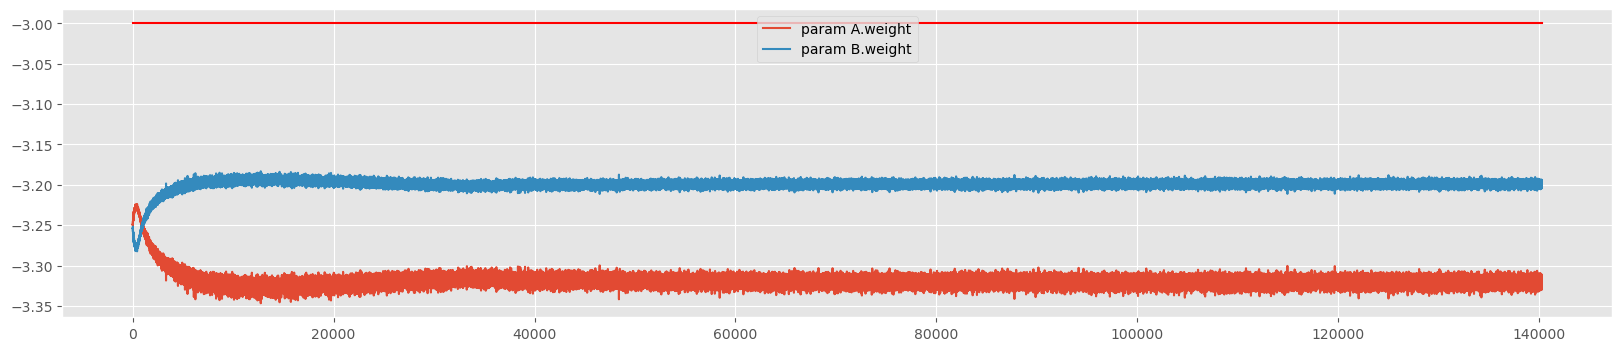

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
legends = []
for i, (name, p) in enumerate(model.named_parameters()):
    plt.plot([ratios[j][i] for j in range(len(ratios))])
    legends.append('param {}'.format(name))
plt.plot([0, len(ratios)], [-3, -3], 'r')
plt.legend(legends)

How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.